# Purpose:
- There are so many errors with multi-matching errors
- Figure out why, and how to deal with them.
- Do I need to curate the master ROI map manually?

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scripts import roi_collection_across_sessions as rcas
from importlib import reload

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]

In [2]:
# Check failed ROI match back sessions
mice = expert_mice_df.mouse.unique()
planes = np.arange(1,9)
roi_error_planes = []
for mouse in mice:
    for pn in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{pn}'
        cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_roi_collection.npy'
        if not cp_roi_collection_results_fn.exists():
            roi_error_planes.append((mouse, pn))
print(len(roi_error_planes))

31


In [58]:
roi_error_planes

[(27, 2),
 (27, 5),
 (27, 7),
 (30, 1),
 (30, 2),
 (30, 3),
 (30, 4),
 (30, 5),
 (30, 6),
 (30, 7),
 (30, 8),
 (36, 1),
 (36, 2),
 (36, 3),
 (36, 4),
 (36, 5),
 (36, 8),
 (39, 1),
 (39, 2),
 (39, 3),
 (39, 4),
 (39, 5),
 (39, 6),
 (39, 7),
 (39, 8),
 (52, 2),
 (52, 3),
 (52, 5),
 (52, 6),
 (52, 7),
 (52, 8)]

In [3]:
test_i = 0
mouse, plane = roi_error_planes[test_i]
master_map_results = np.load(base_dir / f'{mouse:03}' / f'plane_{plane}' / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy', allow_pickle=True).item()
print(mouse, plane)
print(master_map_results.keys())


27 2
dict_keys(['master_map_list', 'session_map_list', 'viable_cell_index_list', 'new_master_map_list', 'new_map_list', 'session_nums'])


In [4]:
master_map_results['master_map_list'][-1].shape

(340, 327, 627)

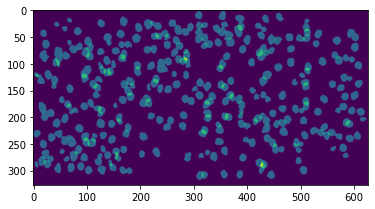

In [8]:
master_map = master_map_results['master_map_list'][-1]
from matplotlib import pyplot as plt
plt.imshow(master_map.sum(axis=0))

In [55]:
import os
rerun = True
pn = plane
if isinstance(base_dir, Path):
    h5_dir = str(base_dir) + '/'
else:
    h5_dir = base_dir
planeDir = f'{h5_dir}{mouse:03}/plane_{pn}/'
master_roi_fn = f'{planeDir}JK{mouse:03}_plane{pn}_cellpose_master_roi.npy'
if not os.path.isfile(master_roi_fn):
    raise(f'JK{mouse:03} plane {pn} master ROI map not found.')
else:
    save_fn = f'{planeDir}JK{mouse:03}_plane{pn}_cellpose_roi_session_to_master.npy'
if os.path.isfile(save_fn) and (rerun==False):
    print(f'JK{mouse:03} plane {pn} processed already.')
else:
    master_roi = np.load(master_roi_fn, allow_pickle=True).item()
    master_map_list = master_roi['master_map_list']
    session_map_list = master_roi['session_map_list']
    viable_cell_index_list = master_roi['viable_cell_index_list']
    session_nums = master_roi['session_nums']
    num_sessions = len(session_nums)

    print(f'Re-matching with master ROI map: JK{mouse:03} plane {pn}')
    master_map = master_map_list[-1]
    # master_area = np.sum(master_map, axis=(1,2))

    matching_master_roi_index_list = []
    for si in range(num_sessions):
        snum = session_nums[si]
        sname = f'{mouse:03}_{snum:03}'
        print(f'Processing re-matching JK{mouse:03} plane {pn} {sname} {si}/{num_sessions-1}')

        session_map = session_map_list[si]
        # session_area = np.sum(session_map, axis=(1,2))
        viable_cell_index = viable_cell_index_list[si] # This has the same order as the session_map    
        numCell = len(viable_cell_index)

        if session_map.shape[0] != numCell:
            raise('Session map and index mismatch.')

        iou = np.zeros((master_map.shape[0], numCell), 'float32')
        
        for ci in range(numCell):
            intersection = np.sum(master_map*session_map[ci,:,:], axis=(1,2))
            union = np.sum(master_map + session_map[ci,:,:], axis=(1,2))
            iou[:,ci] = intersection / union
        
        # Take the maximum overlap per ROI in each session map.
        session_matching_master_roi_index = np.argmax(iou, axis=0)
        if len(np.unique(session_matching_master_roi_index)) < len(session_matching_master_roi_index):
            # When there are multiple cells matched to the same master ROI, choose the one with the largest iou
            # and set the rest to -1
            multi_matched_ind = []
            for unique_ind in np.unique(session_matching_master_roi_index):
                if len(np.where(session_matching_master_roi_index==unique_ind)[0])>1:
                    multi_matched_ind.append(unique_ind)
            for mi in multi_matched_ind:
                session_matched_inds = np.where(session_matching_master_roi_index==mi)[0]
                assert len(session_matched_inds) > 1
                # Choose the one with the largest iou, and set the rest to -1
                session_matched_ious = iou[mi, session_matched_inds]
                max_ind = np.argmax(session_matched_ious)
                # session_matching_master_roi_index[session_matched_inds[max_ind]] = mi                
                session_matching_master_roi_index[session_matched_inds[np.arange(len(session_matched_inds))!=max_ind]] = -1
        matching_master_roi_index_list.append(session_matching_master_roi_index)

Re-matching with master ROI map: JK027 plane 2
Processing re-matching JK027 plane 2 027_001 0/6
Processing re-matching JK027 plane 2 027_002 1/6
Processing re-matching JK027 plane 2 027_003 2/6
Processing re-matching JK027 plane 2 027_004 3/6
Processing re-matching JK027 plane 2 027_005 4/6
Processing re-matching JK027 plane 2 027_006 5/6
Processing re-matching JK027 plane 2 027_007 6/6


In [57]:
[np.where(mri==-1)[0] for mri in matching_master_roi_index_list]

[array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([54], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64)]

In [11]:
multi_matched_ind

[99]

In [10]:
unique_ind

325

In [12]:
np.where(session_matching_master_roi_index==99)[0]

array([54, 97], dtype=int64)

In [13]:
master_map.shape

(340, 327, 627)

In [19]:
import napari
viewer = napari.Viewer()
viewer.add_image(session_map[[54,97],:,:])
viewer.add_image(master_map[99,:,:])

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Image [1]' at 0x1d83a455640>

In [16]:
np.sum(session_map[54,:,:] * session_map[97,:,:])

28

In [17]:
np.sum(session_map[54,:,:])

77

In [18]:
np.sum(session_map[97,:,:])

59

In [20]:
overlaps[99,:]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 45,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 59,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0], dtype=uint16)

In [26]:
np.max(master_map + session_map[ci,:,:])

True

In [30]:
iou = np.zeros((master_map.shape[0], numCell), 'float32')
for ci in range(numCell):
    intersection = np.sum(master_map*session_map[ci,:,:], axis=(1,2))
    union = np.sum(master_map + session_map[ci,:,:], axis=(1,2))
    iou[:,ci] = intersection / union

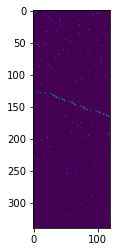

In [31]:
plt.imshow(iou)

In [40]:
temp_matching_master_roi_index = np.argmax(iou, axis=0)

In [41]:
len(np.unique(temp_matching_master_roi_index))

119

In [42]:
len(temp_matching_master_roi_index)

120

In [43]:
multi_matched_ind = []
for unique_ind in np.unique(temp_matching_master_roi_index):
    if len(np.where(temp_matching_master_roi_index==unique_ind)[0])>1:
        multi_matched_ind.append(unique_ind)
print(multi_matched_ind)

[99]


In [36]:
np.where(temp_matching_master_roi_index==99)[0]

array([54, 97], dtype=int64)

In [52]:
matched_master_inds = np.where(iou[:,54])[0]
iou_matched_master_inds = iou[matched_master_inds, 54]
print(matched_master_inds)
print(iou_matched_master_inds)

[52 99]
[0.05555556 0.23809524]


In [53]:
matched_master_inds = np.where(iou[:,97])[0]
iou_matched_master_inds = iou[matched_master_inds, 97]
print(matched_master_inds)
print(iou_matched_master_inds)

[52 99]
[0.17435898 0.37579617]


In [54]:
import napari
viewer = napari.Viewer()
viewer.add_image(session_map[[54,97],:,:])
viewer.add_image(master_map[99,:,:])
viewer.add_image(master_map[52,:,:])

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Image [2]' at 0x1d833d573d0>

### From one example
- JK027 plane 2 session 004
- Too much overlap between two session ROIs
- Each session seems to have unique pattern on the master ROI map
    - Is session-to-session matching from cellpose ROIs really working?
- At least for this example, just removing the one with lower IOU from the session map will solve the issue.
    - Try this and see if there is any other type of errors.

In [59]:
reload(rcas)

<module 'scripts.roi_collection_across_sessions' from 'c:\\Users\\shires\\Dropbox\\Works\\Projects\\2020 Neural stretching in S1\\Analysis\\codes\\scripts\\roi_collection_across_sessions.py'>

In [61]:
roi_error_planes

[(27, 2),
 (27, 5),
 (27, 7),
 (30, 1),
 (30, 2),
 (30, 3),
 (30, 4),
 (30, 5),
 (30, 6),
 (30, 7),
 (30, 8),
 (36, 1),
 (36, 2),
 (36, 3),
 (36, 4),
 (36, 5),
 (36, 8),
 (39, 1),
 (39, 2),
 (39, 3),
 (39, 4),
 (39, 5),
 (39, 6),
 (39, 7),
 (39, 8),
 (52, 2),
 (52, 3),
 (52, 5),
 (52, 6),
 (52, 7),
 (52, 8)]

In [60]:
for mouse, plane in roi_error_planes:
    rcas.run_roi_matching(mouse, plane, base_dir)

Re-matching with master ROI map: JK027 plane 2
Processing re-matching JK027 plane 2 027_001 0/6
Processing re-matching JK027 plane 2 027_002 1/6
Processing re-matching JK027 plane 2 027_003 2/6
Processing re-matching JK027 plane 2 027_004 3/6
Processing re-matching JK027 plane 2 027_005 4/6
Processing re-matching JK027 plane 2 027_006 5/6
Processing re-matching JK027 plane 2 027_007 6/6
JK027 plane 2 saved.
Re-matching with master ROI map: JK027 plane 5
Processing re-matching JK027 plane 5 027_001 0/12
Processing re-matching JK027 plane 5 027_002 1/12
Processing re-matching JK027 plane 5 027_003 2/12
Processing re-matching JK027 plane 5 027_004 3/12
Processing re-matching JK027 plane 5 027_005 4/12
Processing re-matching JK027 plane 5 027_006 5/12
Processing re-matching JK027 plane 5 027_008 6/12
Processing re-matching JK027 plane 5 027_009 7/12
Processing re-matching JK027 plane 5 027_010 8/12
Processing re-matching JK027 plane 5 027_012 9/12
Processing re-matching JK027 plane 5 027_0

In [62]:
mouse = 52
plane = 1
rcas.run_roi_matching(mouse, plane, base_dir)

Re-matching with master ROI map: JK052 plane 1
Processing re-matching JK052 plane 1 052_003 0/15
Processing re-matching JK052 plane 1 052_006 1/15
Processing re-matching JK052 plane 1 052_007 2/15
Processing re-matching JK052 plane 1 052_008 3/15
Processing re-matching JK052 plane 1 052_009 4/15
Processing re-matching JK052 plane 1 052_010 5/15
Processing re-matching JK052 plane 1 052_011 6/15
Processing re-matching JK052 plane 1 052_012 7/15
Processing re-matching JK052 plane 1 052_013 8/15
Processing re-matching JK052 plane 1 052_014 9/15
Processing re-matching JK052 plane 1 052_015 10/15
Processing re-matching JK052 plane 1 052_016 11/15
Processing re-matching JK052 plane 1 052_017 12/15
Processing re-matching JK052 plane 1 052_018 13/15
Processing re-matching JK052 plane 1 052_020 14/15
Processing re-matching JK052 plane 1 052_021 15/15
JK052 plane 1 saved.


# Another idea
- Instead of matching back, I can collect matched, updated, new ROIs at each session addition and follow it during master ROI map generation.
    - Can't do this
        - Because multi-index matching also deals with one-to-many matching cases.
# Go back to re-matching
- Try simply assigning to the best IOU